In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.6.0


In [ ]:
!python --version

Python 3.7.12


In [ ]:
!nvidia-smi

Thu Oct 21 13:40:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
cd "/content/drive/MyDrive/Research/Colorization/Coloring-greyscale-images/Full-version"

/content/drive/MyDrive/Research/Colorization/Coloring-greyscale-images/Full-version


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Layer
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, smart_resize
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random


In [ ]:
# Get Training Set images
Xtrain = []
for filename in os.listdir('Dataset/Train/'):
    Xtrain.append(img_to_array(load_img('Dataset/Train/'+filename)))
Xtrain = np.array(Xtrain, dtype=float)
Xtrain = 1.0/255*Xtrain

In [ ]:
# Get Training Set images
XValidation = []
for filename in os.listdir('Dataset/Validation/'):
    XValidation.append(img_to_array(load_img('Dataset/Validation/'+filename)))
XValidation = np.array(XValidation, dtype=float)
XValidation = 1.0/255*XValidation


In [ ]:
#Load weights
# inception = InceptionResNetV2(weights='imagenet', include_top=True)

#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception = Model(inputs = inception.input, outputs=inception.layers[-2].output)
inception.trainable = False
inception.summary()

225222656/225209952 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                

In [ ]:
def model_creation():

  #Encoder
  encoder_input = Input(shape=(256, 256, 1,))
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)


  embed_input = Input(shape=(1536,))
  #Fusion
  fusion_output = RepeatVector(32 * 32)(embed_input) 
  fusion_output = Reshape(([32, 32, 1536]))(fusion_output)
  fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
  fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 



  #Decoder
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output)
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output)
  decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
  decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
  decoder_output = UpSampling2D((2, 2))(decoder_output)

  model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

  return model

In [ ]:
model = model_creation()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 128, 128, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 128, 128, 128 73856       conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 64, 64, 128)  147584      conv2d_29[0][0]                  
____________________________________________________________________________________________

In [ ]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        #embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


In [ ]:
grayscaled_rgb_val = gray2rgb(rgb2gray(XValidation))
embed_val = create_inception_embedding(grayscaled_rgb_val)
lab_val = rgb2lab(XValidation)
X_val = lab_val[:,:,:,0]
X_val = X_val.reshape(X_val.shape+(1,))
Y_val = lab_val[:,:,:,1:] / 128

In [ ]:


#Train model    
model = model_creation()  

In [ ]:
batch_size = 32
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
history  = model.fit(image_a_b_gen(batch_size), validation_data=([X_val,embed_val],Y_val), epochs=20, steps_per_epoch=10 )

Epoch 1/20
10/10 [==============================] - 49s 4s/step - loss: 0.5162 - accuracy: 0.4382 - val_loss: 0.0068 - val_accuracy: 0.6493
Epoch 2/20
10/10 [==============================] - 28s 3s/step - loss: 0.0036 - accuracy: 0.5982 - val_loss: 0.0030 - val_accuracy: 0.6221
Epoch 3/20
10/10 [==============================] - 26s 3s/step - loss: 0.0028 - accuracy: 0.6177 - val_loss: 0.0030 - val_accuracy: 0.6221
Epoch 4/20
10/10 [==============================] - 26s 3s/step - loss: 0.0029 - accuracy: 0.6703 - val_loss: 0.0030 - val_accuracy: 0.6334
Epoch 5/20
10/10 [==============================] - 29s 3s/step - loss: 0.0029 - accuracy: 0.6615 - val_loss: 0.0030 - val_accuracy: 0.6484
Epoch 6/20
10/10 [==============================] - 26s 3s/step - loss: 0.0033 - accuracy: 0.5366 - val_loss: 0.0031 - val_accuracy: 0.6425
Epoch 7/20
10/10 [==============================] - 27s 3s/step - loss: 0.0029 - accuracy: 0.6561 - val_loss: 0.0030 - val_accuracy: 0.6356
Epoch 8/20
10/10 [==

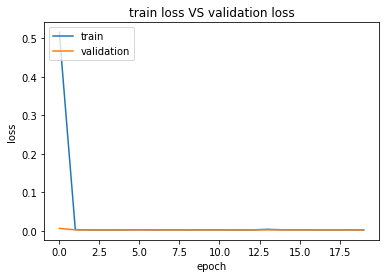

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss VS validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('train_loss_VS_validation_loss.png')
plt.show()


<Figure size 432x288 with 0 Axes>

In [ ]:
# Save model
# model_json = model.to_json()
# with open("modelV1.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("modelweightsV1.h5")
model.save("modelV1.h5")